## Download Data

In [1]:
# !pip install tensorflow==2.8.0

In [2]:
# !pip install -U --no-cache-dir gdown --pre
# #dataset.zip
# !gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F

In [3]:
# !unzip weather-dataset.zip

In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.preprocessing import image


## Weather Recognition

In [3]:
# list đường dẫn các file ảnh
WEATHER_DATA_PATH = 'dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))
len(path_imgs)


6862

In [4]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,dataset\lightning\1862.jpg,lightning
1,dataset\rainbow\0771.jpg,rainbow
2,dataset\fogsmog\4080.jpg,fogsmog
3,dataset\rime\5217.jpg,rime
4,dataset\fogsmog\4509.jpg,fogsmog


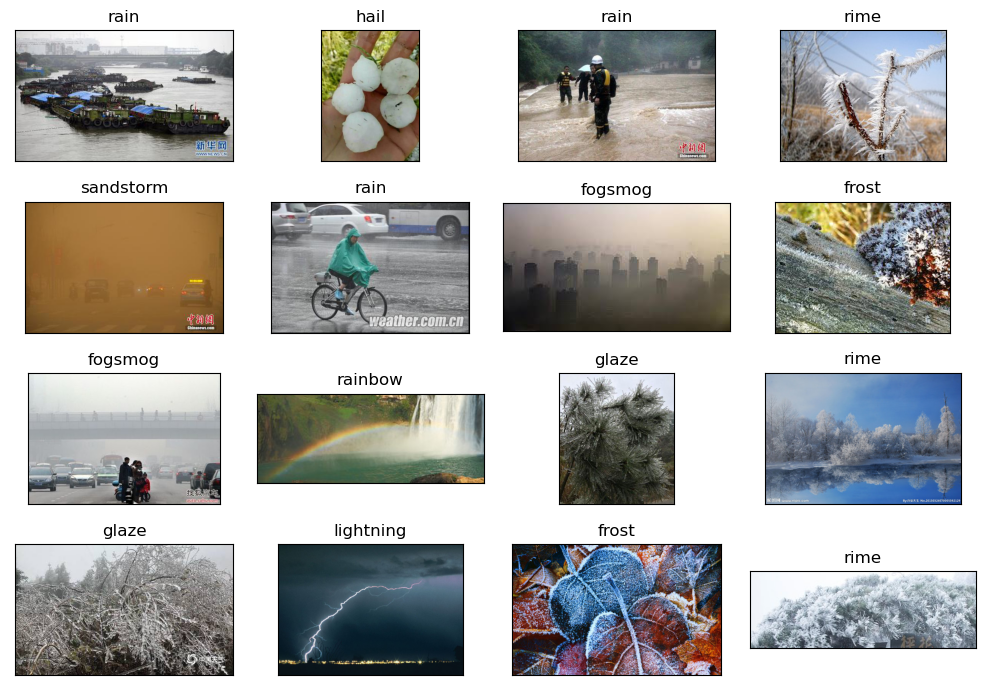

In [8]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()


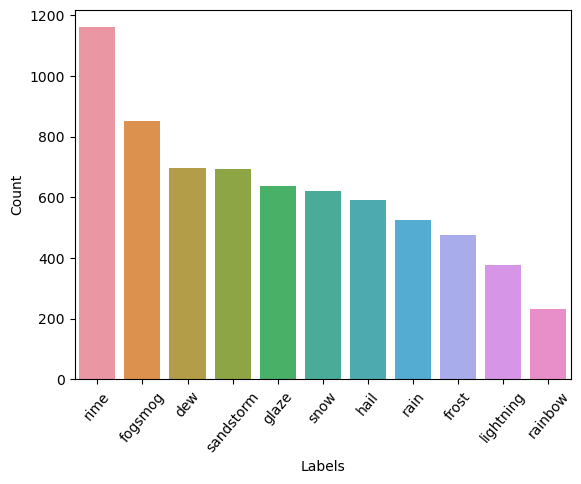

In [10]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

## CONFIG PARAMETERS

In [5]:
batch_size = 32
img_height = 224
img_width = 224

## Data Preprocessing

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


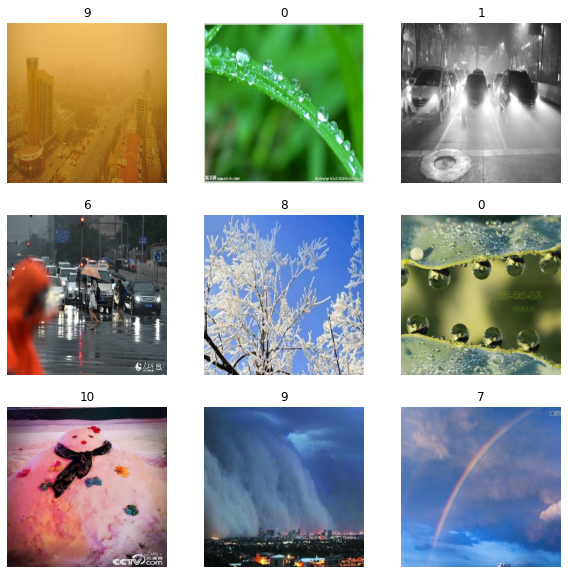

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

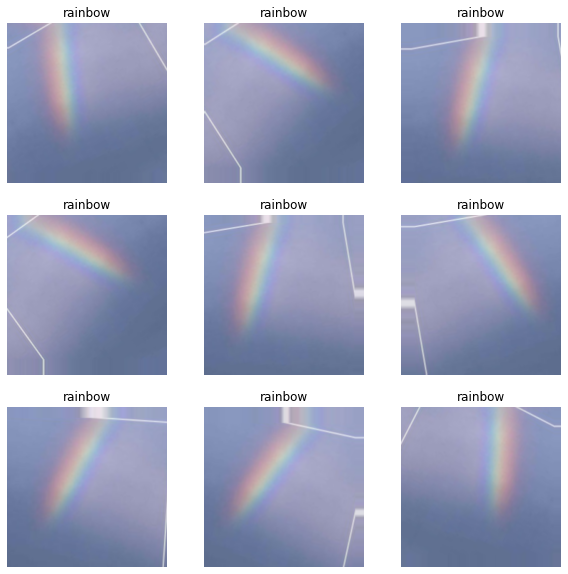

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## ResNet34

In [17]:
class BuildResNet34():
    def __init__(self):
        pass

    def identity_block(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        skip_connection = layers.add([inputs, x])     
        x = layers.Activation('relu')(skip_connection)
        
        return x
    
    
    def projection_block(self, inputs, filters, strides=2):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides, use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                                 strides=strides, use_bias=False)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
        skip_connection = layers.add([shortcut, x])        
        x = layers.Activation('relu')(skip_connection)
        
        return x
    
    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        
        # conv1
        x = layers.ZeroPadding2D(padding=((3, 3)))(inputs)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        
        # conv2_X
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return model
        

In [18]:
build_resnet34 = BuildResNet34()
resnet34_model = build_resnet34.build_model(classes=11)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = resnet34_model(x)
weather_resnet34_model = Model(inputs=image_input, outputs=x)

weather_resnet34_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                21307339  
                                                                 
Total params: 21,307,339
Trainable params: 21,290,315
Non-trainable params: 17,024
_________________________________________________________________


## Train


In [19]:
num_epochs = 50

weather_resnet34_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = weather_resnet34_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/50
172/172 [==============================] - 55s 234ms/step - loss: 1.6953 - accuracy: 0.4457 - val_loss: 5.8005 - val_accuracy: 0.1115
Epoch 2/50
172/172 [==============================] - 39s 221ms/step - loss: 1.2118 - accuracy: 0.5876 - val_loss: 5.0207 - val_accuracy: 0.1429
Epoch 3/50
172/172 [==============================] - 37s 211ms/step - loss: 1.0930 - accuracy: 0.6257 - val_loss: 1.6286 - val_accuracy: 0.4781
Epoch 4/50
172/172 [==============================] - 37s 214ms/step - loss: 1.0411 - accuracy: 0.6454 - val_loss: 1.0783 - val_accuracy: 0.6487
Epoch 5/50
172/172 [==============================] - 37s 211ms/step - loss: 0.9871 - accuracy: 0.6557 - val_loss: 1.1134 - val_accuracy: 0.6297
Epoch 6/50
172/172 [==============================] - 38s 214ms/step - loss: 0.9510 - accuracy: 0.6718 - val_loss: 1.0570 - val_accuracy: 0.6443
Epoch 7/50
172/172 [==============================] - 38s 218ms/step - loss: 0.9284 - accuracy: 0.6791 - val_loss: 1.1102 - val_ac

## Evaluate Model



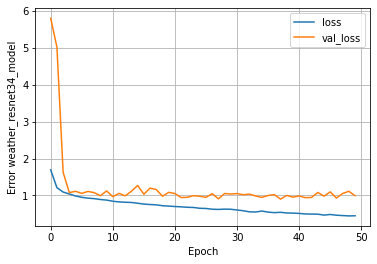

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_resnet34_model')
plt.legend()
plt.grid(True)

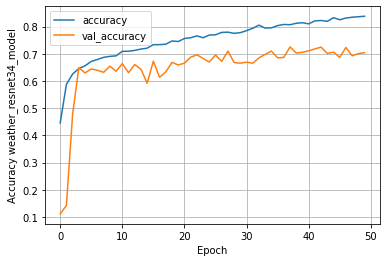

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_resnet34_model')
plt.legend()
plt.grid(True)

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.485485,0.824954,1.097535,0.686589,45
46,0.466226,0.831330,0.931148,0.723032,46
47,0.456198,0.834244,1.055173,0.692420,47
48,0.446756,0.836066,1.113768,0.700437,48
49,0.450397,0.837887,0.993018,0.704082,49


## Save & Load Model

In [24]:
# weather_resnet34_model.save(r'Model\Weather_Recognition_ResNet34_model.h5')

In [8]:
model = keras.models.load_model(r'Model/Weather_Recognition_ResNet34_model.h5')

In [12]:
def search(path):
    img_pred_load = tf.keras.preprocessing.image.load_img(path, target_size=(img_height,img_width))
    img_pred = np.expand_dims(img_pred_load, axis = 0)

    result = model.predict(img_pred)
    max_index = np.argmax(result)
    plt.imshow(img_pred_load)
    plt.title(class_names[max_index], fontweight ="bold")
    plt.axis("off")
    plt.show()

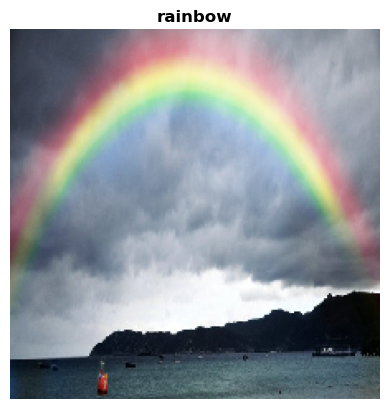

In [13]:
search(r'dataset\rainbow\0822.jpg')